# Import libraries and nk files

In [25]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from matplotlib import cm
import csv
from __future__ import division, print_function, absolute_import
%load_ext autoreload
%autoreload 2
from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

n_all = pd.read_excel('/Users/raymondiacobacci/LeiteLab-6_8/n-allHTMats-2.xlsx')
k_all = pd.read_excel('/Users/raymondiacobacci/LeiteLab-6_8/k-allHTMats.xlsx')

l_i = np.arange(350,3001)#n_all['Wavelength (nm)']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
mat_names = list(n_all.columns.values)[::-1][:-1]
mat_names_f = ['W','Ta','Ru','Re','Os','Nb','Mo','Ir','Hf','WSi$_2$','TaSi$_2$','Mo$_2$Si$_3$(2)'\
               ,'Mo$_2$Si$_3$(1)','MoSi$_2$','ZrB$_2$','TiB$_2$','HfB$_2$','a-HfB$_2$','LaB$_6$'\
               ,'ZrC','VC','TiC','TaC','TaC$_2$','NbC','SiC','C','B$_4$C','a-C','ZrN','VN','TiN'\
               ,'NbN','HfN','ScN','BN','AlN','ZrO$_2$','YSZ','HfO$_2$','Cr$_2$O$_3$','Yb$_2$O$_3$'\
               ,'Y$_2$O$_3$','Sc$_2$O$_3$','Lu$_2$O$_3$','La$_2$O$_3$','Gd$_2$O$_3$','Dy$_2$O$_3$'\
               ,'MgO','CaO','BeO','Al$_2$O$_3$','MgAl$_2$O$_4$']

# Functions

In [27]:
#Main TPV Code
#Constanst
h = 6.626070e-34#Js Planck's constant
c = 2.997925e8#m/s speed of light
k_B = 1.380649e-23#J/K Boltzmann constant
q = 1.602176e-19#C elementary charge

#Blackbody spectral radiance [W/cm2*nm]
Blackbody = lambda lambda_i,T: (2*h*c**2)/((np.exp((h*c)/(k_B*T*lambda_i*1e-9))-1)*lambda_i**5)*1e32
#Photon spectral radiance [photon/cm2*s*nm]
nb_B = lambda lambda_i,T: (2*c)/((np.exp((h*c)/(k_B*T*lambda_i*1e-9))-1)*lambda_i**4)*1e23

T_e = 2073.15#K emitter temperature
B_i = Blackbody(l_i,T_e)#2073.15K blackbody
nb_B_e = nb_B(l_i,T_e)#2073.15K photon
T_PV = 300#K PV temperature
nb_B_PV = nb_B(l_i,T_PV)#300K photon

#getmax - input/output pair, returns max output with associated input value
def get_max(input_array,output_array):
    max_index = np.where(output_array == max(output_array))[0][0]
    input_max = input_array[max_index]
    output_max = output_array[max_index]
    return input_max,output_max

#IQE - returns array of same length as wavelength with value of 1 for lambda<lambda_g (E>E_g)
def IQE(lambda_i,E_g):
    lambda_g = np.ceil(1240/E_g)#nm
    if (lambda_g > lambda_i[-1]):
        l_index = lambda_i[-1]
    else:
        l_index = np.where(lambda_i == lambda_g)[0][0]
    IQE = np.ones(len(lambda_i))
    for i in range(l_index,len(lambda_i)):
        IQE[i]=0
    return IQE

#Current density-Voltage Characteristics - computes JV curve from emitter+bandgap data
def JV(em,IQE,lambda_i,T_emitter):
    J_L = q*sp.integrate.simps(em*nb_B(lambda_i,T_emitter)*IQE,x=lambda_i)
    if J_L == 0:
        V,J,J_sc,V_oc,FF,J_m,V_m,P_cell=0,0,0,0,0,0,0,0
    else:
        J_0 = q*sp.integrate.simps(nb_B_PV*IQE,x=lambda_i)
        J_sc = J_L
        V_oc = (k_B*T_PV/q)*np.log(J_L/J_0+1)

        V = np.linspace(0,V_oc,100)
        J = J_L-J_0*(np.exp(q*V/(k_B*T_PV))-1)
        P = V*J
        V_m,P_m = get_max(V,P)
        J_m = P_m/V_m
        FF = J_m*V_m/(J_sc*V_oc) # Unused
        P_cell = V_m*J_m 
    return V,J,J_sc,V_oc,FF,J_m,V_m,P_cell

#Emissivity Calculations based on multilayer type, very inefficient
def d_emissivity_cs_a(lambda_i,nk_coating,nk_substrate):
    #d iterations
    d = np.arange(1,1001,1)
    emissivity_dataset = np.zeros(len(d),dtype='object')
    for j in range(0,len(d)):
        emissivity = np.zeros(len(lambda_i))
        for i in range(0,len(lambda_i)):
            d_list = [np.inf,d[j],np.inf]
            n_list = [1,nk_coating[i],nk_substrate[i]]
            emissivity[i]=1-coh_tmm('s',n_list, d_list, 0, lambda_i[i])['R']
        emissivity_dataset[j] = emissivity
    return d,emissivity_dataset

#Input wavelength, emitter data, emitter temperature, bandgap
#return Pcell and FOM for the substrate coating pair for each coating layer thickness from 1-1000nm
def d_optimize(lambda_i,emissivity_dataset,T_emitter,E_g_PV):
    #d iterations
    d = emissivity_dataset[0]
    FOM = np.zeros(len(d))
    P_cell = np.zeros(len(d))
    for j in range(0,len(d)):
        emissivity = emissivity_dataset[1][j]
        #Pemit
        P_emit = sp.integrate.simps(emissivity*Blackbody(lambda_i,T_emitter),x=lambda_i)
        #IQE
        IQE_PV = IQE(lambda_i,E_g_PV)
        #JV Characteristics
        JV_PV = JV(emissivity,IQE_PV,lambda_i,T_emitter)
        P_cell[j] = JV_PV[7]
        if P_cell[j] == 0:
            FOM[j] = 0
        else:
            FOM[j] = P_cell[j]/P_emit
    return P_cell,FOM


#Get TPV parameters for specific coating thickness bilayer emitter
def TPV_parameters(lambda_i,emissivity_dataset,T_emitter,E_g_PV,d_coating):
    if d_coating >= 0:
        emissivity = emissivity_dataset
    else:
        d = emissivity_dataset[0]
        emissivity = emissivity_dataset[1]
        d_index = np.where(d == d_coating)[0][0]
        emissivity = emissivity[d_index]
    #Pemit
    P_emit = sp.integrate.simps(emissivity*Blackbody(lambda_i,T_emitter),x=lambda_i)
    #IQE
    IQE_PV = IQE(lambda_i,E_g_PV)
    #JV Characteristics
    JV_PV = JV(emissivity,IQE_PV,lambda_i,T_emitter)
    P_cell = JV_PV[7]
    if P_cell == 0:
        FOM = 0
    else:
        FOM = P_cell/P_emit
    
    return P_emit,JV_PV[2:],FOM,emissivity #P_emit,[J_sc,V_oc,FF,J_m,V_m,P_cell],FOM

# Example for AlN(473nm)/W-GaSb

In [19]:
nk_AlN[0]

(2.22537+0j)

In [18]:
x=np.sqrt(2)
((x-1)/(x+1))**2

0.029437251522859434

In [34]:
#AlN(473nm)/W emitter for GaSb
d_AlN_W = 473#nm
nk_AlN = n_all['AlN']+1j*k_all['AlN']
nk_W = n_all['W']+1j*k_all['W']

emissivity_AlN_W = np.zeros(len(l_i))

# d_list = [np.inf,d_AlN_W,np.inf]
d_list = [np.inf, 473, np.inf]
# n_list = [1, 2, 1]
n_list = [1,2,1]
ans = coh_tmm('p',n_list, d_list, 0, l_i[650])
emissivity_AlN_W[650]=1-ans['R']
print(ans['R'])
print(ans['T'])
# print(emissivity_AlN_W[0])
# print(coh_tmm('s',n_list, d_list, 0, l_i[650])['T'])


Reflection account: (0.3333333333333333+0j)
Transmission account: (0.6666666666666666+0j)
Mtilde (before):
[[0.75 0.25]
 [0.25 0.75]]
Concern matrix:
[[1.5+0.j 0.5+0.j]
 [0.5+0.j 1.5+0.j]]
M_list[1]:
[[0.75 0.25]
 [0.25 0.75]]
Reflection:
0.33333333333333326, 0.11111111111111106
Transferance:
1.3333333333333333, 1.7777777777777777
Mtilde (after):
[[1.03068302 0.24961466]
 [0.24961466 1.03068302]]
0.05865295970626003
0.9413470402937398


In [ ]:
#AlN(473nm)/W emitter for GaSb

arr = []
for rf_idx in np.arange(1, 4, step = 0.1):
    d_AlN_W = 473#nm
    nk_AlN = n_all['AlN']+1j*k_all['AlN']
    nk_W = n_all['W']+1j*k_all['W']

    emissivity_AlN_W = np.zeros(len(l_i))

    d_list = [np.inf,d_AlN_W,np.inf]
    n_list = [1, rf_idx, 1]
    ans = coh_tmm('p',n_list, d_list, 0, l_i[650])
    emissivity_AlN_W[650]=1-ans['R']
    arr.append(ans['T'])
import matplotlib.pyplot as plt
plt.plot(arr)
# print(ans['R'])
# print(ans['T'])
# print(emissivity_AlN_W[0])
# print(coh_tmm('s',n_list, d_list, 0, l_i[650])['T'])


In [34]:
(1/1.0036)**2

0.9928386942121952

In [35]:
(0.08529187/1.0036)**2

0.00722260671476755

In [31]:
.28/.72

0.38888888888888895

In [10]:
%%time
e_set_AlN_W = d_emissivity_cs_a(l_i,nk_AlN,nk_W)

CPU times: user 5min 27s, sys: 3.65 s, total: 5min 30s
Wall time: 5min 37s


In [12]:
%%time
E_g_GaSb = 0.726#eV
T_E = 1800+273#K
AlN_W_GaSb_data = d_optimize(l_i,e_set_AlN_W,T_E,E_g_GaSb)

/var/folders/5n/xz5rf9sn7kdf2905qmv18yrr0000gn/T/ipykernel_63504/730557780.py:81: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  P_emit = sp.integrate.simps(emissivity*Blackbody(lambda_i,T_emitter),x=lambda_i)
/var/folders/5n/xz5rf9sn7kdf2905qmv18yrr0000gn/T/ipykernel_63504/730557780.py:40: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  J_L = q*sp.integrate.simps(em*nb_B(lambda_i,T_emitter)*IQE,x=lambda_i)
/var/folders/5n/xz5rf9sn7kdf2905qmv18yrr0000gn/T/ipykernel_63504/730557780.py:44: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  J_0 = q*sp.integrate.simps(nb_B_PV*IQE,x=lambda_i)


CPU times: user 497 ms, sys: 8.63 ms, total: 506 ms
Wall time: 521 ms


Text(0, 0.5, 'FOM')

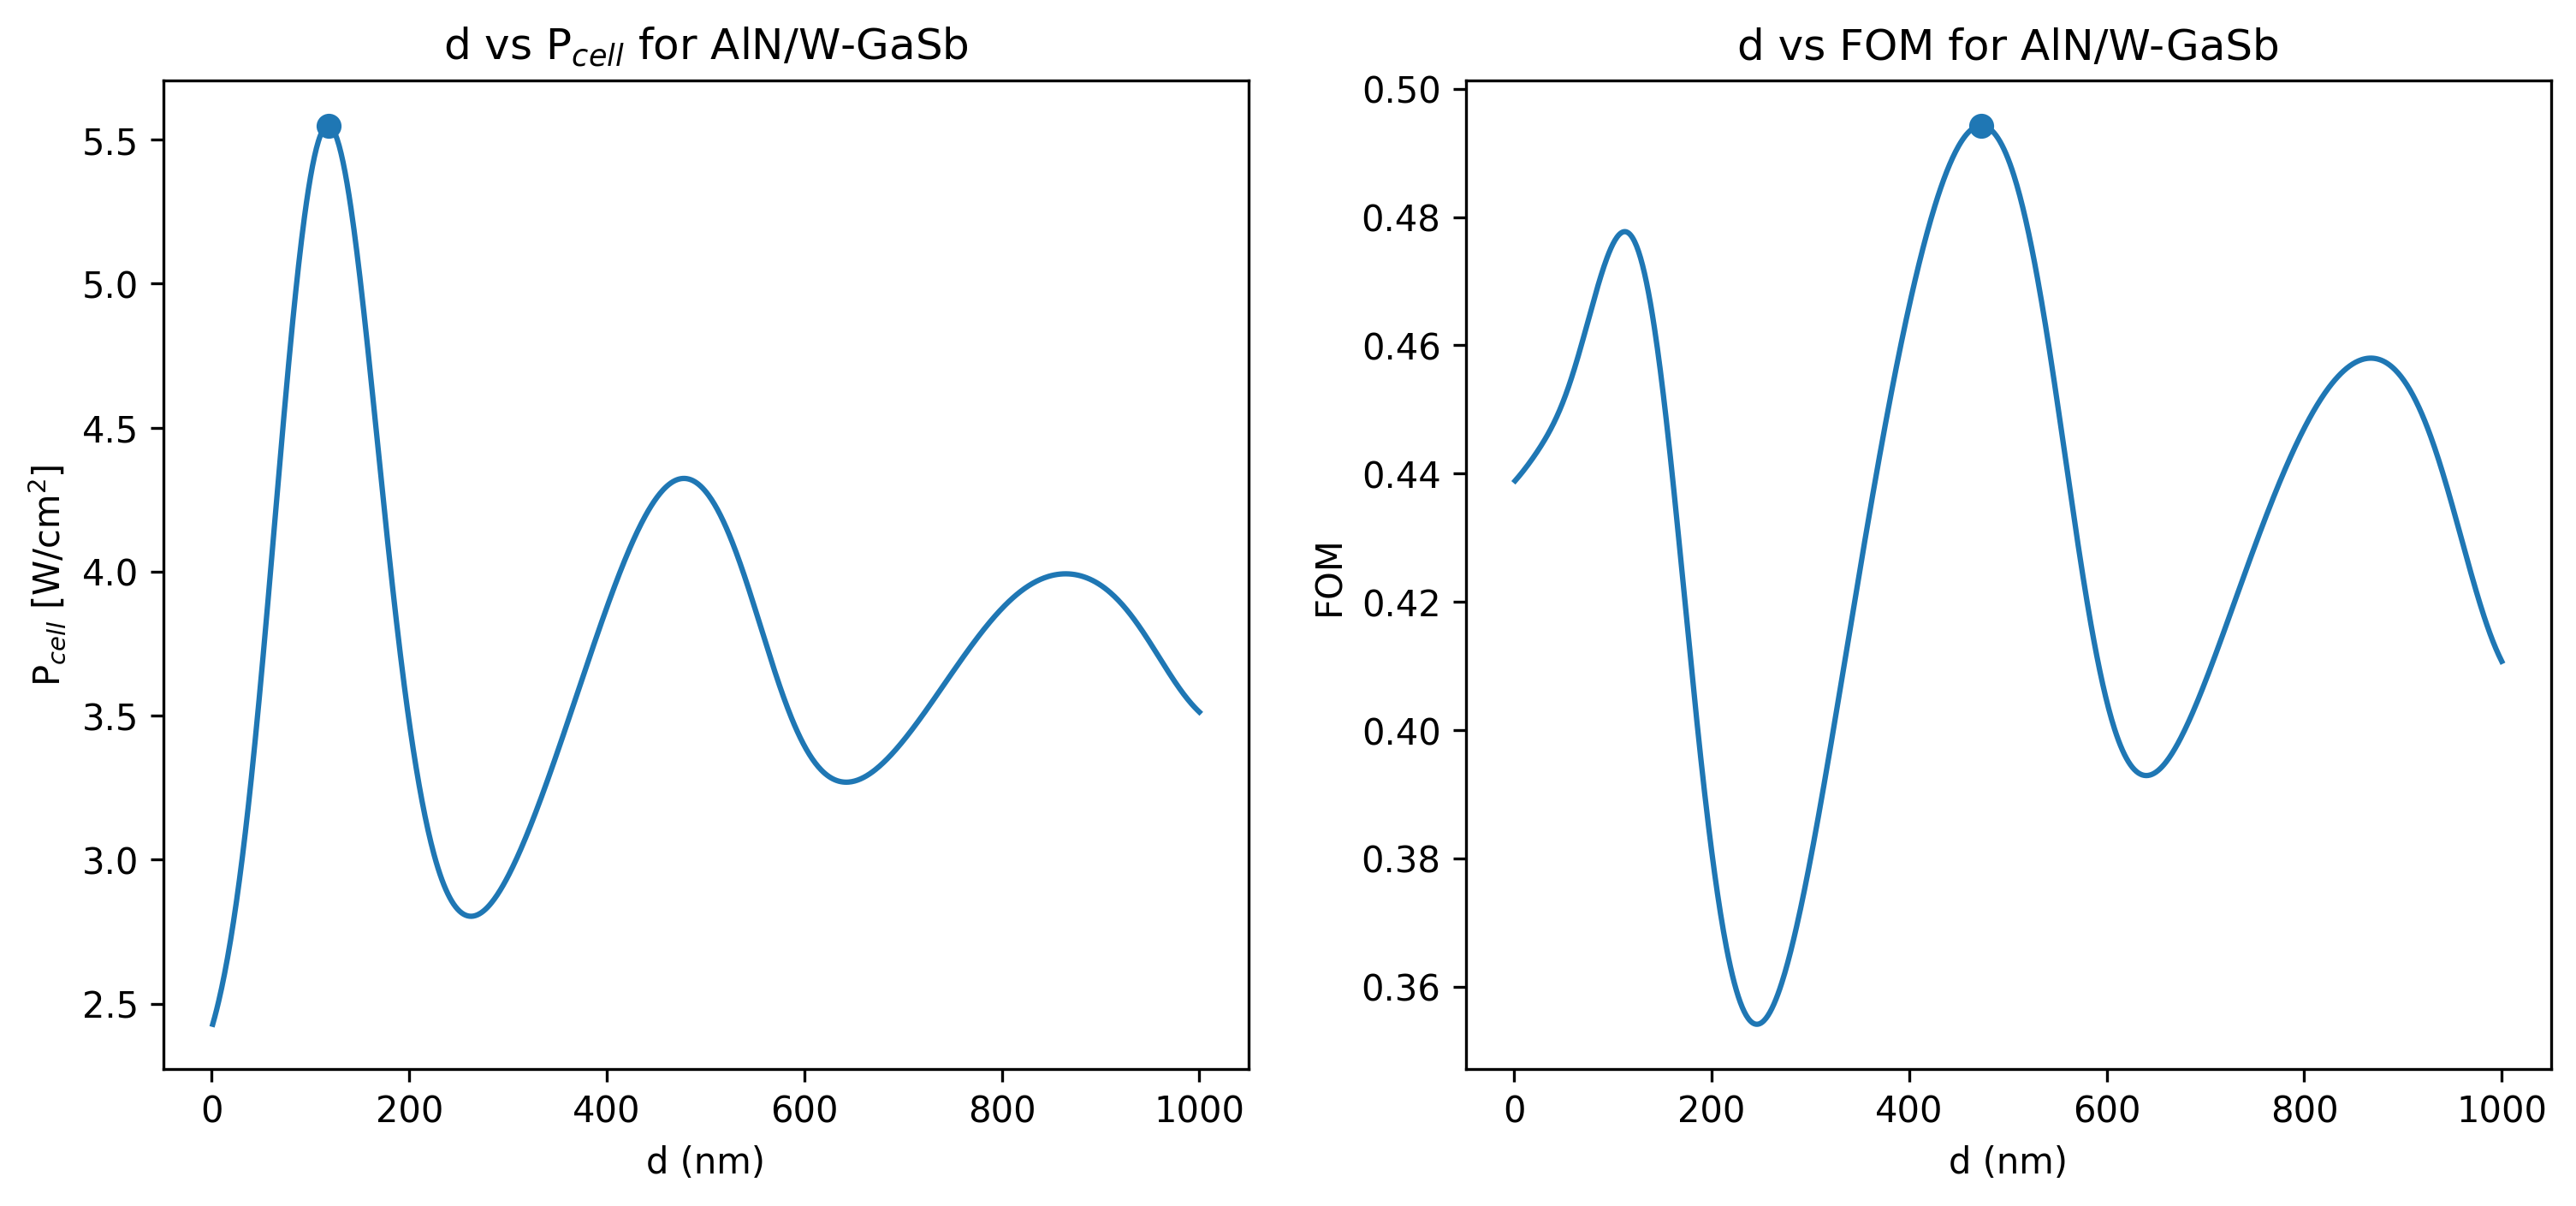

In [13]:
d_AlN_W_GaSb = np.arange(1,1001,1)
P_cell_AlN_W_GaSb = AlN_W_GaSb_data[0]
FOM_AlN_W_GaSb = AlN_W_GaSb_data[1]

d_max_FOM_AlN_W_GaSb = get_max(d_AlN_W_GaSb,FOM_AlN_W_GaSb)[0]
FOM_max_AlN_W_GaSb =get_max(d_AlN_W_GaSb,FOM_AlN_W_GaSb)[1]

d_max_Pcell_AlN_W_GaSb = get_max(d_AlN_W_GaSb,P_cell_AlN_W_GaSb)[0]
Pcell_max_AlN_W_GaSb =get_max(d_AlN_W_GaSb,P_cell_AlN_W_GaSb)[1]

plt.figure(figsize = (12,5),dpi = 300)
plt.subplot(1,2,1)
plt.plot(d_AlN_W_GaSb,P_cell_AlN_W_GaSb)
plt.scatter([d_max_Pcell_AlN_W_GaSb],[Pcell_max_AlN_W_GaSb])
plt.title('d vs P$_{cell}$ for AlN/W-GaSb')
plt.xlabel('d (nm)')
plt.ylabel('P$_{cell}$ [W/cm$^2$]')
plt.subplot(1,2,2)
plt.plot(d_AlN_W_GaSb,FOM_AlN_W_GaSb)
plt.scatter([d_max_FOM_AlN_W_GaSb],[FOM_max_AlN_W_GaSb])
plt.title('d vs FOM for AlN/W-GaSb')
plt.xlabel('d (nm)')
plt.ylabel('FOM')

# 53x53 emitter database

In [14]:
#If you want the data from Joule paper, this is what you'd run iteratively to get all 2809 points
%%time
add_col = 2
old_size = len(TPV_test_2)
new_size = old_size + add_col
TPV_test_3 = np.ones((new_size,new_size),dtype = object)
TPV_test_3[:old_size,:old_size] = TPV_test_2
tot_new = new_size**2-old_size**2-add_col
dun_new = 0
for i in range(0,new_size):
    for j in range(0,new_size):
        substrate = mats[i]
        coating = mats[j]
        if (TPV_test_3[i,j] != 1):
            continue
        else:
            if (coating == substrate):
                TPV_test_3[i,j] = 0
                print(substrate,'stack skipped')
            else:
                TPV_test_3[i,j] = d_optimize(l_i,coating,substrate,T_e,E_g_GaSb)
                dun_new += 1
                print(coating,'/',substrate,'stack finished:',dun_new,'/',tot_new)
TPV_test_2 = TPV_test_3

UsageError: Line magic function `%%time` not found.
